## Bare pretrained Resnet backbone evaluation

In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import cohen_kappa_score, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import os
from torchsummary import summary
import numpy as np

def initialize_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

#initialize_seed(115)

BATCH = 32
label_names = ["D", "G", "A"]
device = "cuda" if torch.cuda.is_available() else "cpu"
efficient_net_dir = "../pretrained_backbone/ckpt_efficientnet_ep50.pt"

c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_images= "../images/train"
train_labels = "../train.csv"
val_images = "../images/val"
val_labels = "../val.csv"
offsite_test_images = "../images/offsite_test"
offsite_test_labels = "../offsite_test.csv"
onsite_test_images = "../images/onsite_test"
onsite_test_labels = "../onsite_test_submission.csv"

## Datasets

In [3]:
class RetinaMultiLabelDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row.iloc[0])
        img = Image.open(img_path).convert("RGB")
        labels = torch.tensor(row[1:].values.astype("float32"))
        if self.transform:
            img = self.transform(img)
        return img, labels

### Image transform

In [4]:
img_size=256
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [5]:
BATCH = 32

train = RetinaMultiLabelDataset(train_labels, train_images, transform = transform)
val = RetinaMultiLabelDataset(val_labels, val_images, transform = transform)

offsite_test = RetinaMultiLabelDataset(offsite_test_labels, offsite_test_images, transform = transform)
onsite_test = RetinaMultiLabelDataset(onsite_test_labels, onsite_test_images, transform = transform)


### Model

In [6]:
class Classifier(nn.Module):
    def __init__(self, backbone = "resnet", dir = None):
        super().__init__()

        if dir == None:
            raise FileNotFoundError
        layers = torch.load(dir)

        if backbone == "resnet":
            self.model = models.resnet18()
            self.model.fc = nn.Linear(self.model.fc.in_features, 3)
        elif backbone == "efficientnet":
            self.model = models.efficientnet_b0()
            self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 3)
        else:
            raise ValueError("Unsupported backbone")
        self.model.load_state_dict(layers)
    
    def forward(self, X):
        return self.model(X)
        
model = Classifier(backbone="efficientnet", dir = efficient_net_dir).to(device)
summary(model, (3, 256, 256), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              SiLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              SiLU-6         [-1, 32, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 128]             512
      BatchNorm2d-14         [-1, 16, 1

## No fine-tuning: Evaluation directly on ODIR test set

In [7]:
def eval_model(model, dataset, csv_file = None, report = False):

    loader = DataLoader(dataset, BATCH, shuffle=False)
    preds = []
    model.eval()
    with torch.no_grad():
        for X, _ in tqdm(loader):
            output = (nn.functional.sigmoid(model(X.to(device))) > 0.5).long()
            preds.extend(output.cpu().numpy())

    preds = np.stack(preds)
    if report:
        cr = classification_report(dataset.data[label_names].to_numpy(), preds, target_names=label_names, zero_division= np.nan)
        print(cr)
    if csv_file:
        data = dataset.data.copy()
        data[label_names] = preds
        data.to_csv(csv_file, index = False)

### Onsite

In [8]:
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:01<00:00,  6.81it/s]

              precision    recall  f1-score   support

           D       0.75      0.29      0.42       140
           G       0.44      0.78      0.56        49
           A       0.30      0.64      0.41        22

   micro avg       0.49      0.44      0.47       211
   macro avg       0.50      0.57      0.46       211
weighted avg       0.63      0.44      0.45       211
 samples avg       0.50      0.43      0.37       211



### Offsite

![](efficientnet_no_tuning.png)

In [9]:
eval_model(model, onsite_test, "efficient_submission_notune.csv")

100%|██████████| 8/8 [00:01<00:00,  6.44it/s]


## Frozen backbone, fine-tuning classifier only

In [10]:
params = model.parameters()
for layer in params:
        layer.requires_grad = False
for param in model.model.classifier[1].parameters():
        param.requires_grad = True
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              SiLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              SiLU-6         [-1, 32, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 128]             512
      BatchNorm2d-14         [-1, 16, 1

In [11]:
checkpoints_dir = "../trained_models/"


def train_model(model, train_data, eval_data, optimizer, criterion, epochs, stepLR = None, checkpoint_name = None):
    train_loader = DataLoader(train_data,  BATCH, shuffle=True)
    val_loader = DataLoader(eval_data, BATCH, shuffle=False)
    train_size = len(train_data.data)
    eval_size = len(eval_data.data)

    train_losses = []
    val_losses = []

    f1 = []
    accuracy = []
    best_score = np.inf
    for i in range(epochs):
        model.train()
        train_loss = 0
        val_loss = 0
        val_f1 = 0
        val_accuracy = 0

        for (X, Y) in tqdm(train_loader, desc = "Training"):
            optimizer.zero_grad()
            output = model(X.to(device))
            loss = criterion(output, Y.to(device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)
            
        train_loss = train_loss / train_size

        model.eval()
        true = []
        preds = []
        with torch.no_grad():
            for (X, Y) in tqdm(val_loader, desc="Validation"):
                output = model(X.to(device))
                loss = criterion(output, Y.to(device))
                val_loss += loss.item() * X.size(0)
                output = nn.functional.sigmoid(output)
                output = (output > 0.5).cpu().long().numpy()
                true.extend(Y.cpu().numpy())
                preds.extend(output)

        val_loss = val_loss / eval_size
        val_accuracy = accuracy_score(preds, true)
        val_f1 = f1_score(preds, true,average='macro', zero_division=0)

        print(f"Epoch: {i} - Train Loss: {train_loss:2f} - Val Loss: {val_loss:2f} - Val Accuracy: {val_accuracy:2f} - Val F1 (macro): {val_f1:2f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        #saving model if score imporved
        if best_score > val_loss:
            print("Model improved! Saving if checkpoint_name is set.")
            best_score = val_loss
            if checkpoint_name != None:
                torch.save(model.state_dict(), checkpoints_dir + checkpoint_name)
        f1.append(val_f1)
        accuracy.append(val_accuracy)
        if stepLR != None:
                stepLR.step()
    
    x = range(0, epochs)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(x, train_losses, label = "Train Loss")
    plt.plot(x, val_losses, label = "Val Loss")
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.title("BCE Loss")
    plt.subplot(1, 3, 2)
    plt.plot(x, f1)
    plt.title("Val F1 (macro)")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.subplot(1, 3, 3)
    plt.plot(x, accuracy)
    plt.title("Val accuracy")
    plt.ylabel("Metric")
    plt.xlabel("Epoch")
    plt.show()

    return train_losses, val_losses, f1, accuracy

20 Epochs with small reduction after 10, lr 1e-3 and moderate weight decay

Validation: 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


Epoch: 0 - Train Loss: 1.078800 - Val Loss: 0.686436 - Val Accuracy: 0.375000 - Val F1 (macro): 0.588858
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch: 1 - Train Loss: 0.488332 - Val Loss: 0.520026 - Val Accuracy: 0.595000 - Val F1 (macro): 0.627989
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch: 2 - Train Loss: 0.431117 - Val Loss: 0.462712 - Val Accuracy: 0.630000 - Val F1 (macro): 0.628847
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.50it/s]


Epoch: 3 - Train Loss: 0.406602 - Val Loss: 0.454932 - Val Accuracy: 0.650000 - Val F1 (macro): 0.664469
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]


Epoch: 4 - Train Loss: 0.394593 - Val Loss: 0.470247 - Val Accuracy: 0.645000 - Val F1 (macro): 0.605054


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch: 5 - Train Loss: 0.377469 - Val Loss: 0.441114 - Val Accuracy: 0.680000 - Val F1 (macro): 0.682194
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Epoch: 6 - Train Loss: 0.368914 - Val Loss: 0.441600 - Val Accuracy: 0.690000 - Val F1 (macro): 0.682564


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch: 7 - Train Loss: 0.373323 - Val Loss: 0.458021 - Val Accuracy: 0.670000 - Val F1 (macro): 0.643741


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.29it/s]


Epoch: 8 - Train Loss: 0.361160 - Val Loss: 0.438008 - Val Accuracy: 0.665000 - Val F1 (macro): 0.662802
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.97it/s]


Epoch: 9 - Train Loss: 0.353110 - Val Loss: 0.423861 - Val Accuracy: 0.685000 - Val F1 (macro): 0.689734
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.53it/s]


Epoch: 10 - Train Loss: 0.355403 - Val Loss: 0.419816 - Val Accuracy: 0.670000 - Val F1 (macro): 0.678175
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch: 11 - Train Loss: 0.349463 - Val Loss: 0.434251 - Val Accuracy: 0.685000 - Val F1 (macro): 0.690396


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch: 12 - Train Loss: 0.339626 - Val Loss: 0.423341 - Val Accuracy: 0.685000 - Val F1 (macro): 0.684044


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch: 13 - Train Loss: 0.340009 - Val Loss: 0.418743 - Val Accuracy: 0.680000 - Val F1 (macro): 0.687252
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch: 14 - Train Loss: 0.346300 - Val Loss: 0.412750 - Val Accuracy: 0.690000 - Val F1 (macro): 0.674111
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch: 15 - Train Loss: 0.338747 - Val Loss: 0.413636 - Val Accuracy: 0.685000 - Val F1 (macro): 0.677290


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch: 16 - Train Loss: 0.333015 - Val Loss: 0.415213 - Val Accuracy: 0.685000 - Val F1 (macro): 0.677526


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch: 17 - Train Loss: 0.333809 - Val Loss: 0.417721 - Val Accuracy: 0.695000 - Val F1 (macro): 0.687618


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch: 18 - Train Loss: 0.329165 - Val Loss: 0.411007 - Val Accuracy: 0.670000 - Val F1 (macro): 0.682131
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.65it/s]


Epoch: 19 - Train Loss: 0.322248 - Val Loss: 0.405568 - Val Accuracy: 0.690000 - Val F1 (macro): 0.683153
Model improved! Saving if checkpoint_name is set.


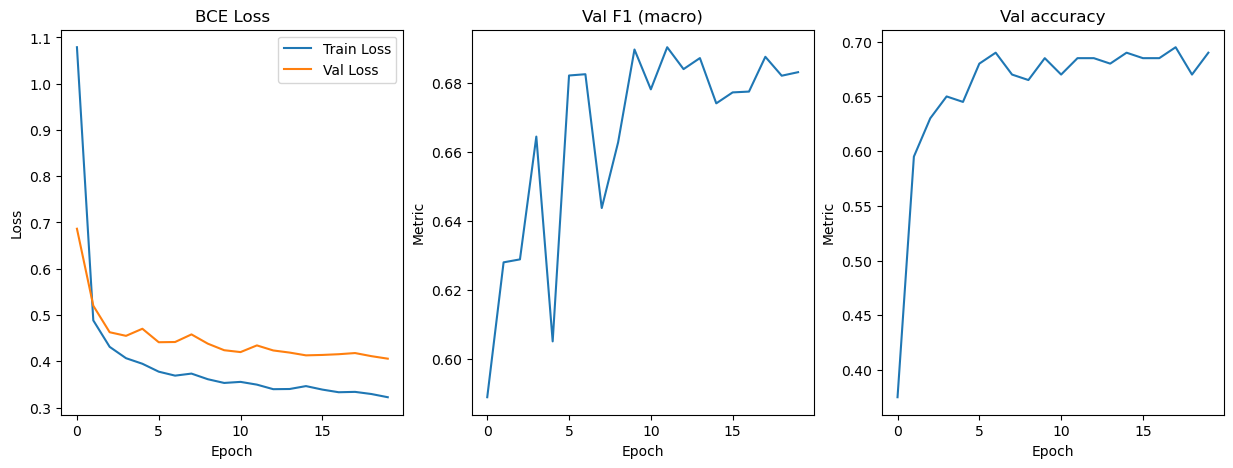

In [12]:
optimizer = torch.optim.AdamW(model.model.classifier[1].parameters(), lr = 1e-3, weight_decay=1e-4) #1e-4
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10, gamma=0.8)
result = train_model(model, train, val, optimizer, criterion, epochs=20, stepLR=scheduler, checkpoint_name="efficient_tuned_classifer.pt")

### Offsite test

In [13]:
model = Classifier(backbone="efficientnet", dir = efficient_net_dir).to(device)
model.load_state_dict(torch.load(checkpoints_dir + "efficient_tuned_classifer.pt"))
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:01<00:00,  6.99it/s]

              precision    recall  f1-score   support

           D       0.82      0.88      0.85       140
           G       0.76      0.51      0.61        49
           A       0.83      0.45      0.59        22

   micro avg       0.81      0.75      0.78       211
   macro avg       0.80      0.61      0.68       211
weighted avg       0.81      0.75      0.77       211
 samples avg       0.82      0.77      0.77       211



### Onsite test
![](efficientnet_classifier_tuning.png)

In [14]:
eval_model(model, onsite_test, "efficient_net_submission_classifier_tune.csv")

100%|██████████| 8/8 [00:01<00:00,  6.57it/s]


## Full fine-tuning

Only 5 epochs no more, with aggressive start and exponential reduction, starting lr = 5e-4 seem to be most optimal, no weight decay

Validation: 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


Epoch: 0 - Train Loss: 0.319825 - Val Loss: 0.427847 - Val Accuracy: 0.685000 - Val F1 (macro): 0.717244
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]


Epoch: 1 - Train Loss: 0.151385 - Val Loss: 0.403418 - Val Accuracy: 0.730000 - Val F1 (macro): 0.759260
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch: 2 - Train Loss: 0.107895 - Val Loss: 0.393536 - Val Accuracy: 0.725000 - Val F1 (macro): 0.750873
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Epoch: 3 - Train Loss: 0.106315 - Val Loss: 0.383906 - Val Accuracy: 0.740000 - Val F1 (macro): 0.756378
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


Epoch: 4 - Train Loss: 0.101648 - Val Loss: 0.403233 - Val Accuracy: 0.735000 - Val F1 (macro): 0.750602


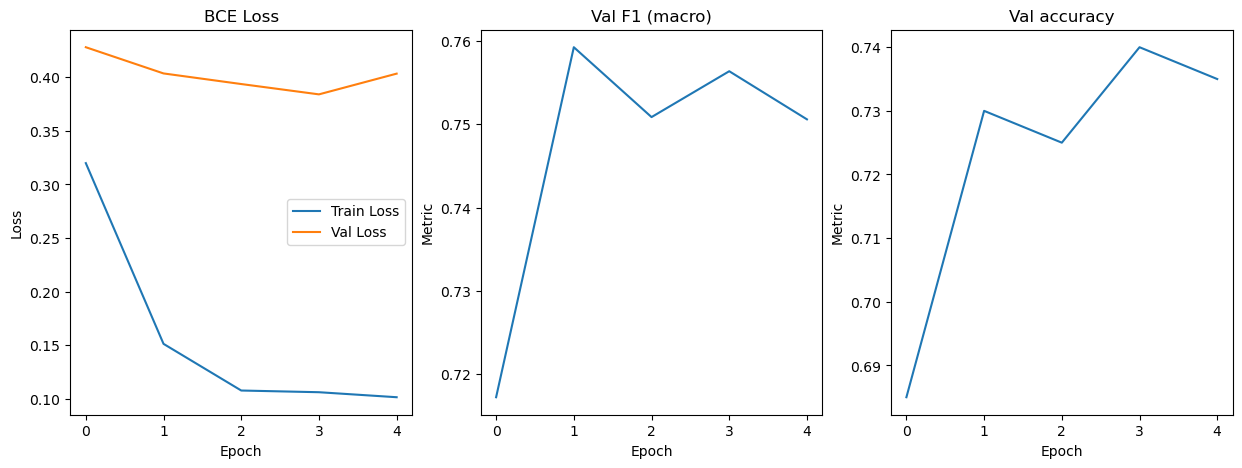

In [15]:
for p in model.parameters():
    p.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, weight_decay = 0)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.2)
result = train_model(model, train, val, optimizer=optimizer, criterion=criterion, epochs=5, stepLR=scheduler, checkpoint_name="efficient.pt")

### Offsite

In [16]:
model = Classifier(backbone="efficientnet", dir = efficient_net_dir).to(device)
model.load_state_dict(torch.load(checkpoints_dir + "efficient.pt"))
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:01<00:00,  6.66it/s]

              precision    recall  f1-score   support

           D       0.91      0.87      0.89       140
           G       0.82      0.73      0.77        49
           A       0.61      0.64      0.62        22

   micro avg       0.86      0.82      0.83       211
   macro avg       0.78      0.75      0.76       211
weighted avg       0.86      0.82      0.84       211
 samples avg       0.86      0.83      0.83       211



### Onsite test
![](efficientnet_classifier_full.png)

In [17]:
eval_model(model, onsite_test, "efficient_net_submission_full.csv")

100%|██████████| 8/8 [00:01<00:00,  6.36it/s]
